# Basic Tutorial

This tutorial will integrate a small multi-modal dataset of PBMCs from the 2022 NeurIPS challenge.
We have taken a subset of this data (donor ID 32606 on day 4) consisting of 10,933 cells.
This demonstration will provide a quick overview of how our model works.

In [1]:
# For local use only
# import os
# os.environ['NUMBA_CACHE_DIR'] = '/scratch/st-jiaruid-1/yinian/tmp/' # https://github.com/scverse/scanpy/issues/2113
# os.environ['MPLCONFIGDIR'] = "/scratch/st-jiaruid-1/yinian/tmp/"

In [2]:
import anndata as ad
import matplotlib.pyplot as plt
import muon as mu
import numpy as np
import scanpy as sc
import sklearn

2024-08-22 15:59:43.469731: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 15:59:44.802738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2024-08-22 15:59:44.802762: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from scPairing.scPairing import scPairing

## Load the data

First, we load the scRNA-seq and scATAC-seq data.

In [4]:
!gzip -d data/pbmc_rna.h5ad.gz
!gzip -d data/pbmc_atac.h5ad.gz

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
rna_adata = ad.read_h5ad('data/pbmc_rna.h5ad')
atac_adata = ad.read_h5ad('data/pbmc_atac.h5ad')

Store the counts in `layers['counts']`

In [5]:
rna_adata.layers['counts'] = rna_adata.X.copy()
atac_adata.layers['counts'] = atac_adata.X.copy()

Store binarized counts in `layers['binary']`

In [6]:
atac_adata.layers['binary'] = sklearn.preprocessing.binarize(atac_adata.X)

### Compute low-dimension representations

Since this data is only one batch and is relatively simple, we will use simple PCA and LSI workflows to get embeddings.

In [7]:
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata)

In [8]:
sc.pp.pca(rna_adata, n_comps=10, use_highly_variable=True)

In [9]:
mu.atac.pp.tfidf(atac_adata)
mu.atac.tl.lsi(atac_adata, n_comps=10)

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/muon/_atac/preproc.py:106: RuntimeWarning: divide by zero encountered in divide
  idf = np.asarray(adata.shape[0] / adata.X.sum(axis=0)).reshape(-1)


## Make and train the model

The raw counts for scRNA-seq is in the `raw` layer and the binarized scATAC-seq counts is in the `binary` layer.

In this example, we will not use the full decoder.
Thus, the model only decodes up to the low-dimension representations.

In [10]:
model = scPairing(
    rna_adata,
    atac_adata,
    counts_layer=['counts', 'binary'],
    transformed_obsm=['X_pca', 'X_lsi'],
    use_decoder=False,
    cosine_loss=True,
    seed=0
)

In [11]:
model.train(epochs = 300)

[2024-08-21 20:58:21,781] INFO - scPairing.logging_utils: UnsupervisedTrainer.__init__(Model(
  (mod1_encoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (mod2_encoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (var_encoder): ConcentrationEncoder(
    (mod1_encoder): Sequential(
      (0): Linear(in_features=10, out_features=32, bias=True)
      (1): ELU(alpha=1.0)
      (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_fea

[2024-08-21 20:58:22,852] INFO - scPairing.trainers.UnsupervisedTrainer: ==========Epoch 0==========
[2024-08-21 20:58:22,854] INFO - scPairing.trainers.UnsupervisedTrainer: lr          :        0.005
[2024-08-21 20:58:22,855] INFO - scPairing.trainers.UnsupervisedTrainer: kl_weight   :        0.001
[2024-08-21 20:58:22,857] INFO - scPairing.trainers.trainer_utils: loss        :      23.12
[2024-08-21 20:58:22,858] INFO - scPairing.trainers.trainer_utils: contrastive :      13.52
[2024-08-21 20:58:22,859] INFO - scPairing.trainers.trainer_utils: KL          :    0.05296
[2024-08-21 20:58:22,860] INFO - scPairing.trainers.trainer_utils: mod1_loss   :      9.004
[2024-08-21 20:58:22,862] INFO - scPairing.trainers.trainer_utils: mod2_loss   :      1.301
[2024-08-21 20:58:22,863] INFO - scPairing.trainers.trainer_utils: temp        :      14.29
[2024-08-21 20:58:22,864] INFO - scPairing.trainers.trainer_utils: modality_discriminative:     0.7413
[2024-08-21 20:58:22,866] INFO - scPairing.t

[2024-08-21 20:59:21,873] INFO - scPairing.trainers.UnsupervisedTrainer: ==========Epoch 300==========
[2024-08-21 20:59:21,875] INFO - scPairing.trainers.UnsupervisedTrainer: lr          :     0.004531
[2024-08-21 20:59:21,876] INFO - scPairing.trainers.UnsupervisedTrainer: kl_weight   :        0.001
[2024-08-21 20:59:21,878] INFO - scPairing.trainers.trainer_utils: loss        :      4.163
[2024-08-21 20:59:21,879] INFO - scPairing.trainers.trainer_utils: contrastive :      3.629
[2024-08-21 20:59:21,881] INFO - scPairing.trainers.trainer_utils: KL          :      11.33
[2024-08-21 20:59:21,882] INFO - scPairing.trainers.trainer_utils: mod1_loss   :      1.771
[2024-08-21 20:59:21,884] INFO - scPairing.trainers.trainer_utils: mod2_loss   :     0.3464
[2024-08-21 20:59:21,885] INFO - scPairing.trainers.trainer_utils: temp        :      31.07
[2024-08-21 20:59:21,886] INFO - scPairing.trainers.trainer_utils: modality_discriminative:     0.6756
[2024-08-21 20:59:21,888] INFO - scPairing

### Evaluate the model

First, get the representations from the comment latent space. The function returns a tuple of representations for the first modality then second modality.

In [12]:
latents = model.get_latent_representation()

Store the representations in the AnnDatas

In [13]:
rna_adata.obsm['mod1_features'] = atac_adata.obsm['mod1_features'] = latents[0]
rna_adata.obsm['mod2_features'] = atac_adata.obsm['mod2_features'] = latents[1]

Evaluate cell pairing using FOSCTTM

In [14]:
from scPairing.eval_utils import foscttm

In [15]:
res = foscttm(rna_adata.obsm['mod1_features'], atac_adata.obsm['mod2_features'])
res[0].mean(), res[1].mean()

(0.005897901078610998, 0.0066083139674932645)

Evaluate clustering and co-embedding of cells:

For clustering, we can concatenate the two representations together for a joint representation.

In [16]:
concat = np.concatenate((rna_adata.obsm['mod1_features'], atac_adata.obsm['mod2_features']), axis=1)
rna_adata.obsm['concat'] = concat

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


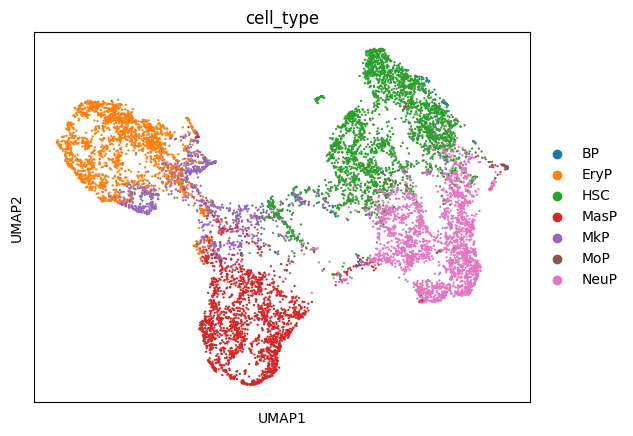

In [17]:
sc.pp.neighbors(rna_adata, use_rep='concat', random_state=0)
sc.tl.umap(rna_adata, min_dist=0.1, random_state=0)
sc.pl.umap(rna_adata, color='cell_type', ncols=1)

We can also visualize the mixing of the two modalities in the common embedding space.

In [18]:
concat_feat = np.concatenate([rna_adata.obsm['mod1_features'], atac_adata.obsm['mod2_features']])

In [19]:
# Repeating the adata twice
concat = ad.concat([rna_adata, rna_adata], label='modality', keys=['RNA', 'ATAC'])
concat.obsm['concat_feat'] = concat_feat

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


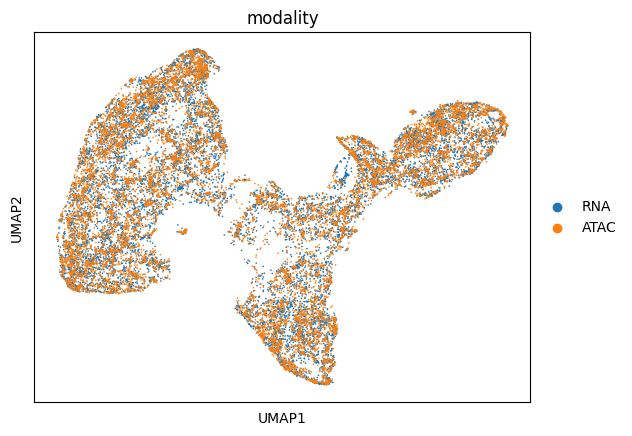

In [20]:
sc.pp.neighbors(concat, use_rep='concat_feat', random_state=0)
sc.tl.umap(concat, min_dist=0.1, random_state=0)
sc.pl.umap(concat, color=['modality'], ncols=1)

Verify that the cell embeddings are somewhat spread out over the hypersphere, and the two modalities overlap.

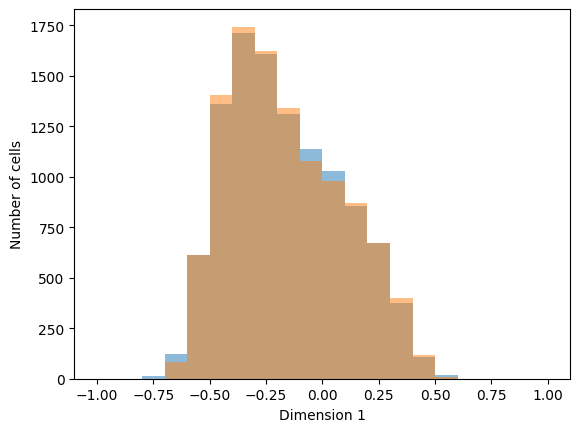

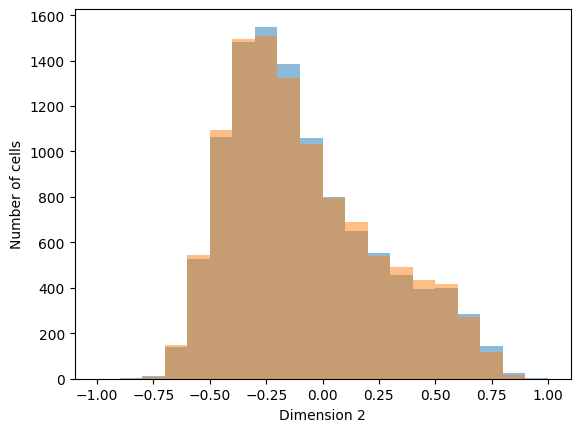

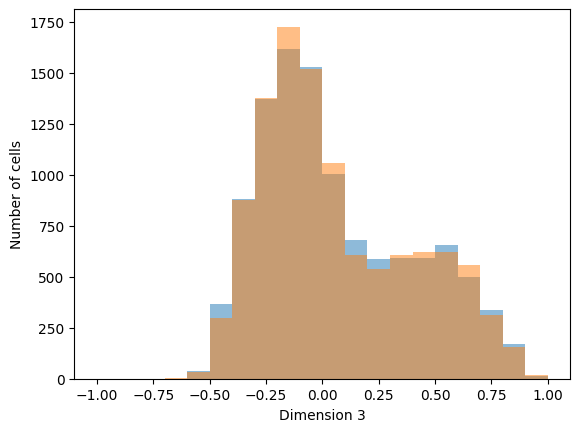

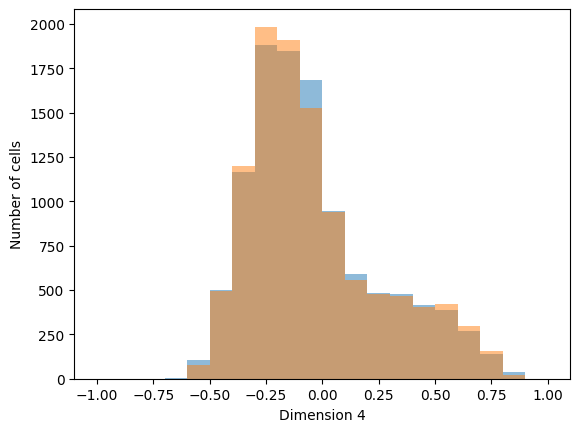

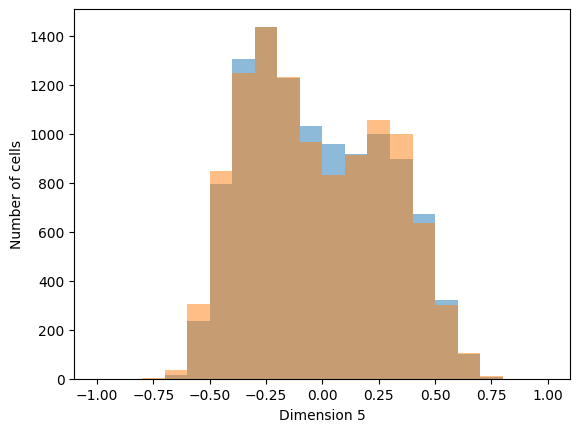

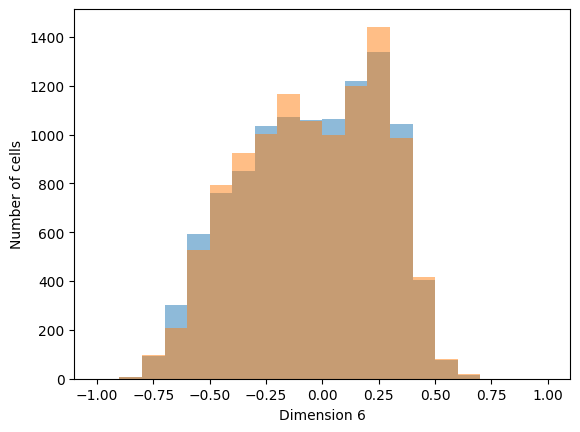

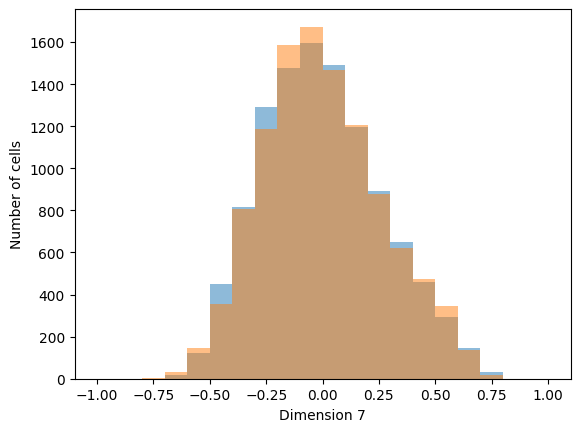

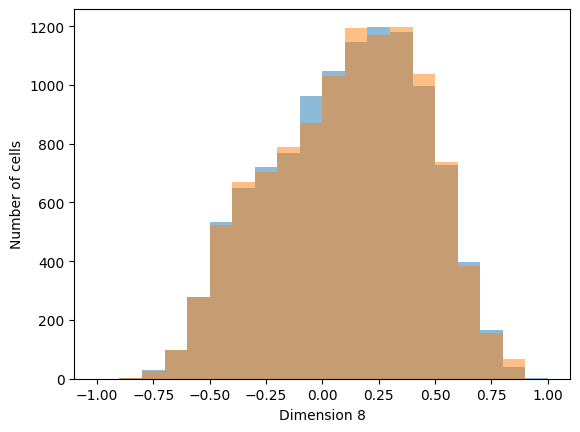

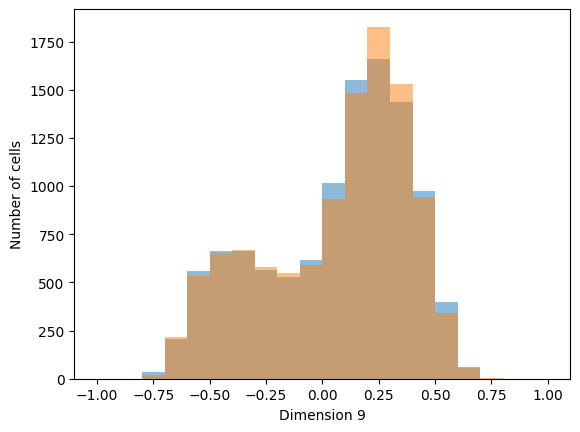

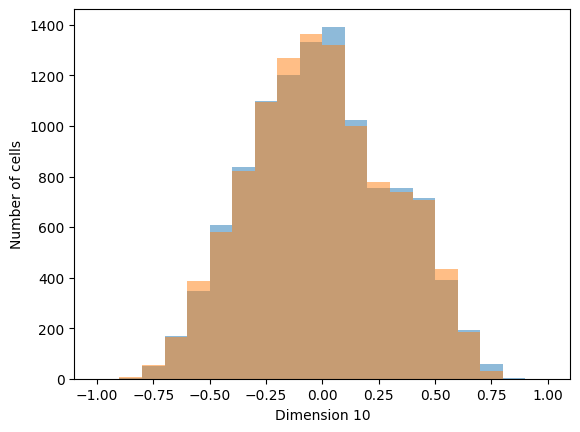

In [21]:
for i in range(10):
    plt.hist(rna_adata.obsm['mod1_features'][:, i], alpha=0.5, label='rna', bins=[-1, -.9, -.8, -.7, -.6, -.5, -.4, -.3, -.2, -.1, 0, .1, .2, .3, .4, .5, .6, .7, .8,.9, 1])
    plt.hist(rna_adata.obsm['mod2_features'][:, i], alpha=0.5, label='atac', bins=[-1, -.9, -.8, -.7, -.6, -.5, -.4, -.3, -.2, -.1, 0, .1, .2, .3, .4, .5, .6, .7, .8,.9, 1])

    plt.xlabel(f"Dimension {i+1}")
    plt.ylabel(f"Number of cells")
    plt.show()